In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from scipy.optimize import curve_fit
from typing import Callable, List, Optional, Tuple

%config InlineBackend.figure_format='retina'

# preset figure size, font size and font type
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})

In [2]:
# example data plots
def get_data(path: str) -> Tuple:
    """
    Get x and y data points.
    Data should be in an excel file, with the first column named "x" and the second column named "Raw."
    
    Parameters:
    -----
    path: path to access excel file
    
    Returns:
    -----
    x_data: x data as a numpy array
    y_data: y data as a numpy array
    
    """
    data = pd.read_excel(path) 
    x_data = np.array(data["x"].tolist(), dtype="float64")
    y_data = np.array(data["Raw"].tolist(), dtype="float64")
    
    return x_data, y_data
    

In [3]:
def linear(x, a, b):
    return a*x+b

In [4]:
def mag(R1: tuple, R2: tuple):
    """
    Get distance between two points.
    """
    return np.sqrt((R2[0]-R1[0])**2+(R2[1]-R1[1])**2)

In [5]:
def fit_and_assess(xpart: np.ndarray, ypart: np.ndarray, x_data: np.ndarray, y_data: np.ndarray):
    """ 
    Fit x and y data with a linear function.
    
    Parameters:
    -----
    xpart: x data to fit
    ypart: y data to fit
    x_data: x_list
    y_data: y_list
    
    Returns:
    -----
    a_fit: slope of fit line
    b_fit: y-intercept of fit line
    r2: R-squared, indicative of goodness of fit
    xpartvals: x values for plotting
    ypartvals: y values for plotting
    ypart_fit_ori: y values for computing R squared and RMSD
    """
    # part 1 fit
    popt, pcov = curve_fit(linear, xpart, ypart)
    a_fit = popt[0]
    b_fit = popt[1]
    print("Fit parameters:", popt) # slope and y-intercept

    xpartvals = np.linspace(np.min(x_data), np.max(x_data), 1000)
    ypart_fit = linear(xpartvals, a_fit, b_fit)
    ypart_fit_ori = linear(xpart, a_fit, b_fit)

    # calculate goodness of fit
    # R squared
    r2 = 1 - np.var(ypart - ypart_fit_ori)/np.var(ypart)
    print("R squared: ", r2)

    # RMSD (Root mean squared deviation)
    RMSD = np.sqrt(np.mean((ypart - ypart_fit_ori)**2))
    print("RMSD: ", RMSD)

    return a_fit, b_fit, r2, xpartvals, ypart_fit, ypart_fit_ori

In [6]:
def get_orthogonal(slope1: float, intercept1: float, point: tuple):
    """
    Given the slope and y-intercept of one line, and a point on this line,
    return the slope and y_intercept of the orthogonal line that passes through this point.
    
    Parameters:
    -----
    slope1: slope of line 1
    intercept1: y-intercept of line 1
    point: point in line 1, in the form (x, y), where x and y are coordinates of the point   
    
    Returns:
    -----
    slope2: slope of orthogonal line (line 2)
    intercept2: y-intercept of line 2
    """
    slope2 = -1/slope1
    # x coordinate of point
    x = point[0]
    
    # y coordinate of point
    y = point[1]
    
    intercept2 = y - slope2*x
    
    return slope2, intercept2
    

In [7]:
# get intersection between part 1 fit and part 3

from __future__ import division 

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        R = (x,y)
        print("Intersection detected:", R)
        return R
    else:
        print("No single intersection point detected")
        return False

In [8]:
# find cliff region

def find_cliff(x_data: np.ndarray, y_data: np.ndarray, ydrop_perc_param: float = 5) -> Tuple:
    """
    Find the data points that correspond to the cliff region.
    
    Parameters:
    -----
    x_data: x data points. (unit in angstroms)
    y_data: y data points. (unit in microns)
    ydrop_perc_param: If y data points changes more than ydrop_perc_param*100 % than previous averages, 
        then a cliff has been detected.
        
    Returns:
    -----
    x_cliff: x data points in the identified cliff region
    y_cliff: y data points in the identified cliff region
    """
    xpart3 = []
    ypart3 = []
    ydrop_sum = 0 # cumulative drop
    ydrop_cma = 0 # cumulative moving average drop
    cliff_inds = [] # indices of cliff range
    
    for i in range(1, len(y_data)):
        ydrop = abs(y_data[i] - y_data[i-1])
        ydrop_sum += ydrop
        ydrop_cma = ydrop_sum/(i+1)
        ydrop_perc = np.abs(ydrop-ydrop_cma)/ydrop_cma
        
        if ydrop_perc >= ydrop_perc_param: # cliff region detected
            cliff_inds.append(i)
            xpart3.append(x_data[i])
            ypart3.append(y_data[i])
            
    xpart3 = np.array(xpart3, dtype="float64")
    ypart3 = np.array(ypart3, dtype="float64")
    print("cliff indices:", cliff_inds)
    xpart3extra = x_data[(np.min(cliff_inds)-10) : (np.max(cliff_inds)+10)]
    ypart3extra = y_data[(np.min(cliff_inds)-10) : (np.max(cliff_inds)+10)]
    return xpart3, ypart3, xpart3extra, ypart3extra
            
 

In [9]:
def get_orthogonal(slope1: float, intercept1: float, point: tuple):
    """
    Given the slope and y-intercept of one line, and a point on this line,
    return the slope and y_intercept of the orthogonal line that passes through this point.
    
    Parameters:
    -----
    slope1: slope of line 1
    intercept1: y-intercept of line 1
    point: point in line 1, in the form (x, y), where x and y are coordinates of the point   
    
    Returns:
    -----
    slope2: slope of orthogonal line (line 2)
    intercept2: y-intercept of line 2
    """
    slope2 = -1/slope1
    # x coordinate of point
    x = point[0]
    
    # y coordinate of point
    y = point[1]
    
    intercept2 = y - slope2*x
    
    return slope2, intercept2
    

In [10]:
def find_swangle_and_depth(x_data: np.ndarray, y_data:np.ndarray, ydrop_perc_param: float = 5):
    """
    Find the sidewall angle and etch depth given a set of data points.
    
    Assume that the data has only one step function (either left or right step function works).
    
    Parameters:
    -----
    x_data: x data points (unit in angstroms)
    y_data: y data points (unit in microns)
    ydrop_perc_param: If y data points changes more than ydrop_perc_param*100 % than previous averages, 
        then a cliff has been detected.
    
    Returns:
    -----
    swangle: sidewall angle
    delta: etch depth
    
    """
    
    ##### linear fitting #####
    y_data = 0.0001*y_data # convert units to microns
    
    num_fit = 50 # number of points used to perform linear fit for etch surface and bottom
    
    # use the first num_fit number of data points for linear fit part 1
    xpart1 = x_data[: num_fit]
    ypart1 = y_data[: num_fit]
    
    # use the last num_fit number of data points for linear fit part 2
    xpart2 = x_data[-num_fit :]
    ypart2 = y_data[-num_fit :]
    
    # use find_cliff to find data points for linear fit part 3
    xpart3, ypart3, xpart3extra, ypart3extra = find_cliff(x_data, y_data, ydrop_perc_param)
    
    # part 1 fit
    a1_fit, b1_fit, r21, xpartvals1, ypart_fit1, ypart_fit_ori1 = fit_and_assess(xpart1, ypart1, x_data, y_data)

    # part 2 fit
    a2_fit, b2_fit, r22, xpartvals2, ypart_fit2, ypart_fit_ori2 = fit_and_assess(xpart2, ypart2, x_data, y_data)

    # part 3 fit
    a3_fit, b3_fit, r23, xpartvals3, ypart_fit3, ypart_fit_ori3 = fit_and_assess(xpart3, ypart3, x_data, y_data)
    
    # part 3 fit for plotting
    
    ypart_fit_ori3_extra = linear(xpart3extra, a3_fit, b3_fit)
    
    
    ##### get orthogonal projection #####
    # pick two points from the first line
    A = [xpartvals2[0], ypart_fit2[0]]
    B = [xpartvals2[3], ypart_fit2[3]]

    # pick two points from the second line
    C = [xpart3extra[0], ypart_fit_ori3_extra[0]]
    D = [xpart3extra[3], ypart_fit_ori3_extra[3]]

    L1 = line(A, B)
    L2 = line(C, D)
    R1 = intersection(L1, L2) # intersection point
        
    slope2, intercept2 = get_orthogonal(a2_fit, b2_fit, R1)
#     print(f"a2_fit and b2_fit: {a2_fit}, {b2_fit}")
#     print(slope2, intercept2)
    yortho = linear(xpart3extra, slope2, intercept2)
    
    # get intersection of orthogonal projection and part 1 fit
    L3 = line([xpart3extra[1], yortho[1]],[xpart3extra[3], yortho[3]])
    L4 = line([xpartvals1[0], ypart_fit1[0]], [xpartvals1[3], ypart_fit1[3]])
    R2 = intersection(L3, L4)
    
    ##### etch depth #####
    # assume that the etch surface and etch bottom are parallel
    delta = mag(R1, R2)
    print(f"Etch depth: {delta} microns")
    
    
    ##### plot #####
    # plotting
    plt.plot(x_data, y_data, color="navy", marker=".", markersize="3", label="original data")
    plt.scatter(xpart1, ypart1, color="cornflowerblue", label="part 1 data")
    plt.scatter(xpart2, ypart2, color="purple", label="part 2 data")
    plt.scatter(xpart3, ypart3, color="orange", label="part 3 data")

    # plot part 1, part 2, part 3 fit
    plt.plot(xpartvals1, ypart_fit1, color="royalblue", label="part 1 fit")
    plt.plot(xpartvals2, ypart_fit2, color="darkorchid", label="part 2 fit")
    plt.plot(xpart3extra, ypart_fit_ori3_extra, color="red", label="part 3 fit")

    # plot orthogonal projection from part 2 fit to part 1 fit
    plt.plot(xpart3extra, yortho, color="green", label="orthogonal fit")
    plt.scatter(R1[0], R1[1], color="blue", label="intersect b/w parts 2&3")
    plt.scatter(R2[0], R2[1], color="turquoise", label="intersect b/w ortho & 1")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.xlabel(r"x ($\mu$m)")
    plt.ylabel(r"y ($\mu$m)")
    plt.ylim(np.min(y_data)*0.95, np.max(y_data)*1.05)
    plt.show()
    
    return None
    
    

# etched_(PECVD_SiO2)_3min_2

cliff indices: [85, 86, 87, 88, 89, 90, 91, 92]
Fit parameters: [1.14246338e-03 6.92738952e+01]
R squared:  0.6832504139649394
RMSD:  0.011225427042358085
Fit parameters: [1.10098439e-03 6.69034790e+01]
R squared:  0.8080865248854553
RMSD:  0.007742789820165753
Fit parameters: [-0.33024405 97.81865459]
R squared:  0.9337761090783063
RMSD:  0.20151186294543158
Intersection detected: (93.3020650610421, 67.00620315229193)
Intersection detected: (93.2994510122558, 69.38048639027413)
Etch depth: 2.374284676995218 mirons


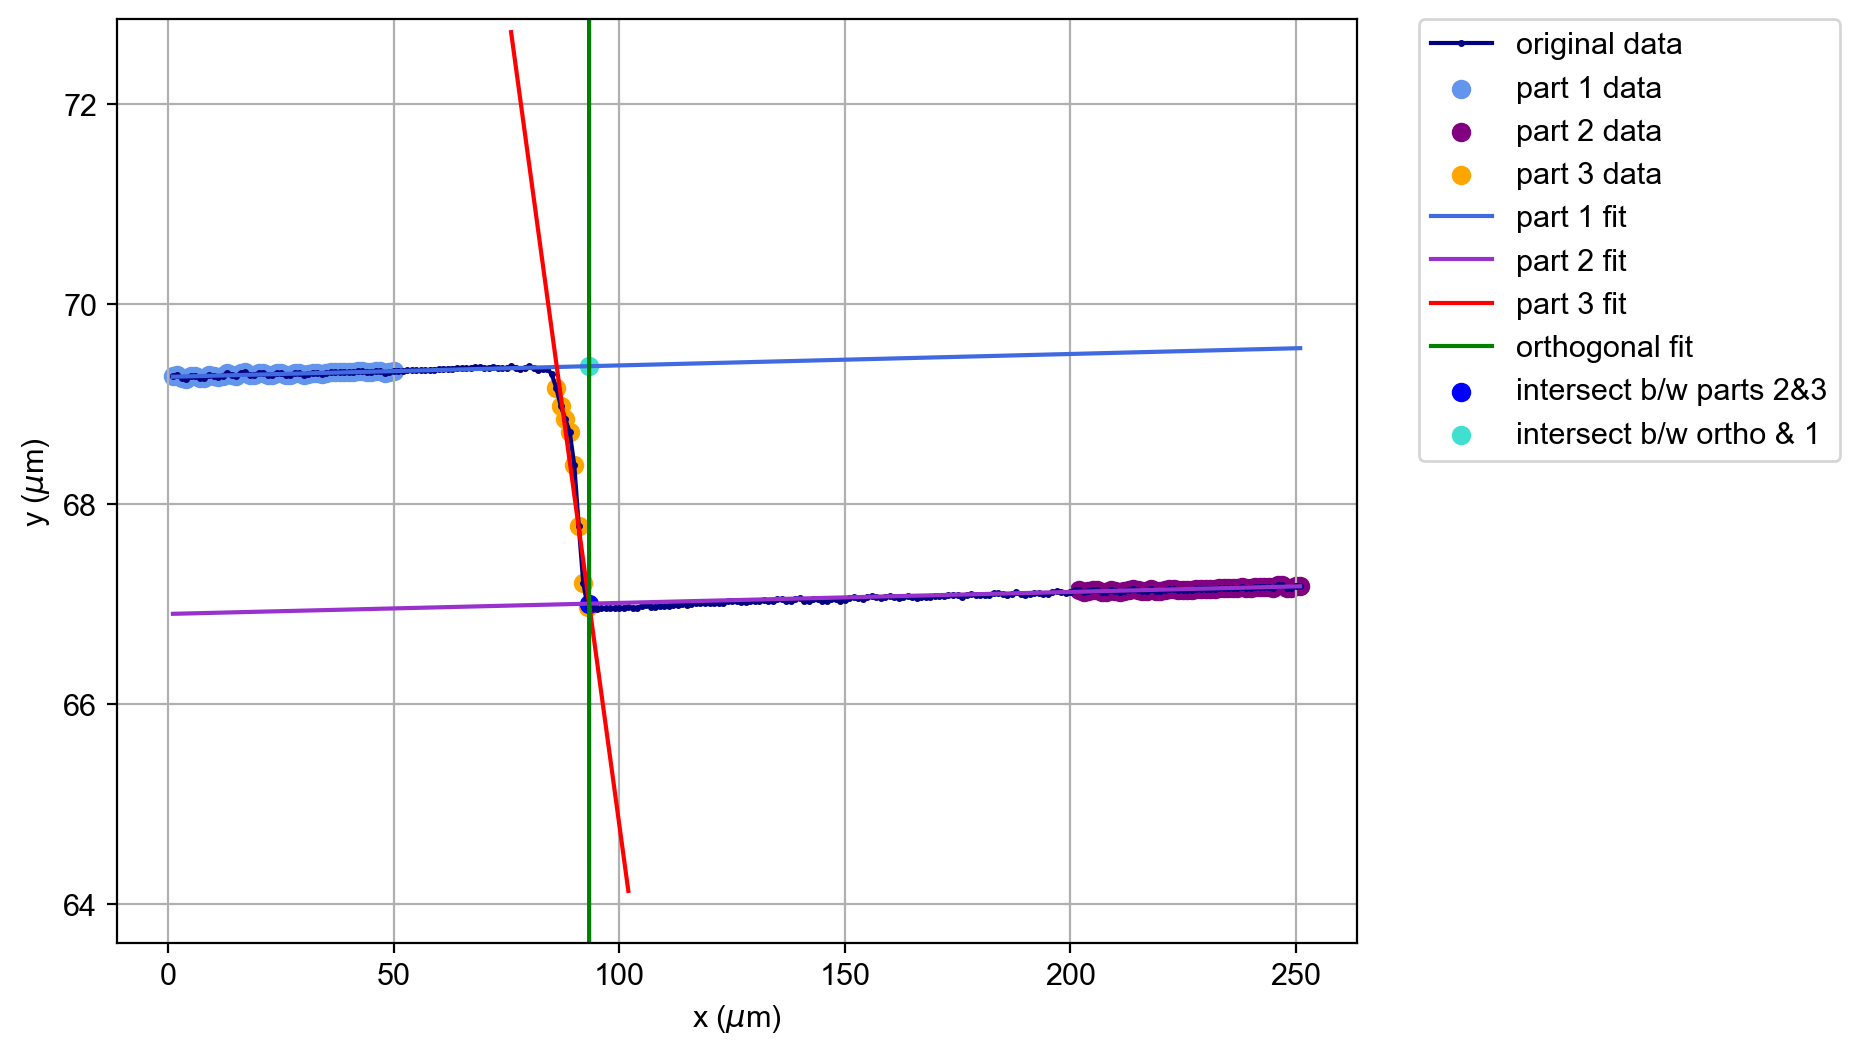

In [11]:
# example data file
data_path = '../sample_data/etch_sample_data/Cl, BCl3/etched_(PECVD_SiO2)_3min_2.xlsx'
x_data, y_data = get_data(data_path)
find_swangle_and_depth(x_data, y_data, 5)

# etched_(Thermal_SiO2)_15sec

cliff indices: [111, 114, 115]
Fit parameters: [-1.62723650e-03 -1.86807375e+01]
R squared:  0.8794462043802936
RMSD:  0.008694187173200538
Fit parameters: [-1.74115246e-03 -1.83360102e+01]
R squared:  0.9107038890633039
RMSD:  0.007867866509376445
Fit parameters: [  0.04563077 -23.92418462]
R squared:  0.9981360590651887
RMSD:  0.0033515400210678485
Intersection detected: (117.96385410927657, -18.541403211251996)
Intersection detected: (117.96327728564843, -18.872691619509716)
Etch depth: 0.33128891042627984 mirons


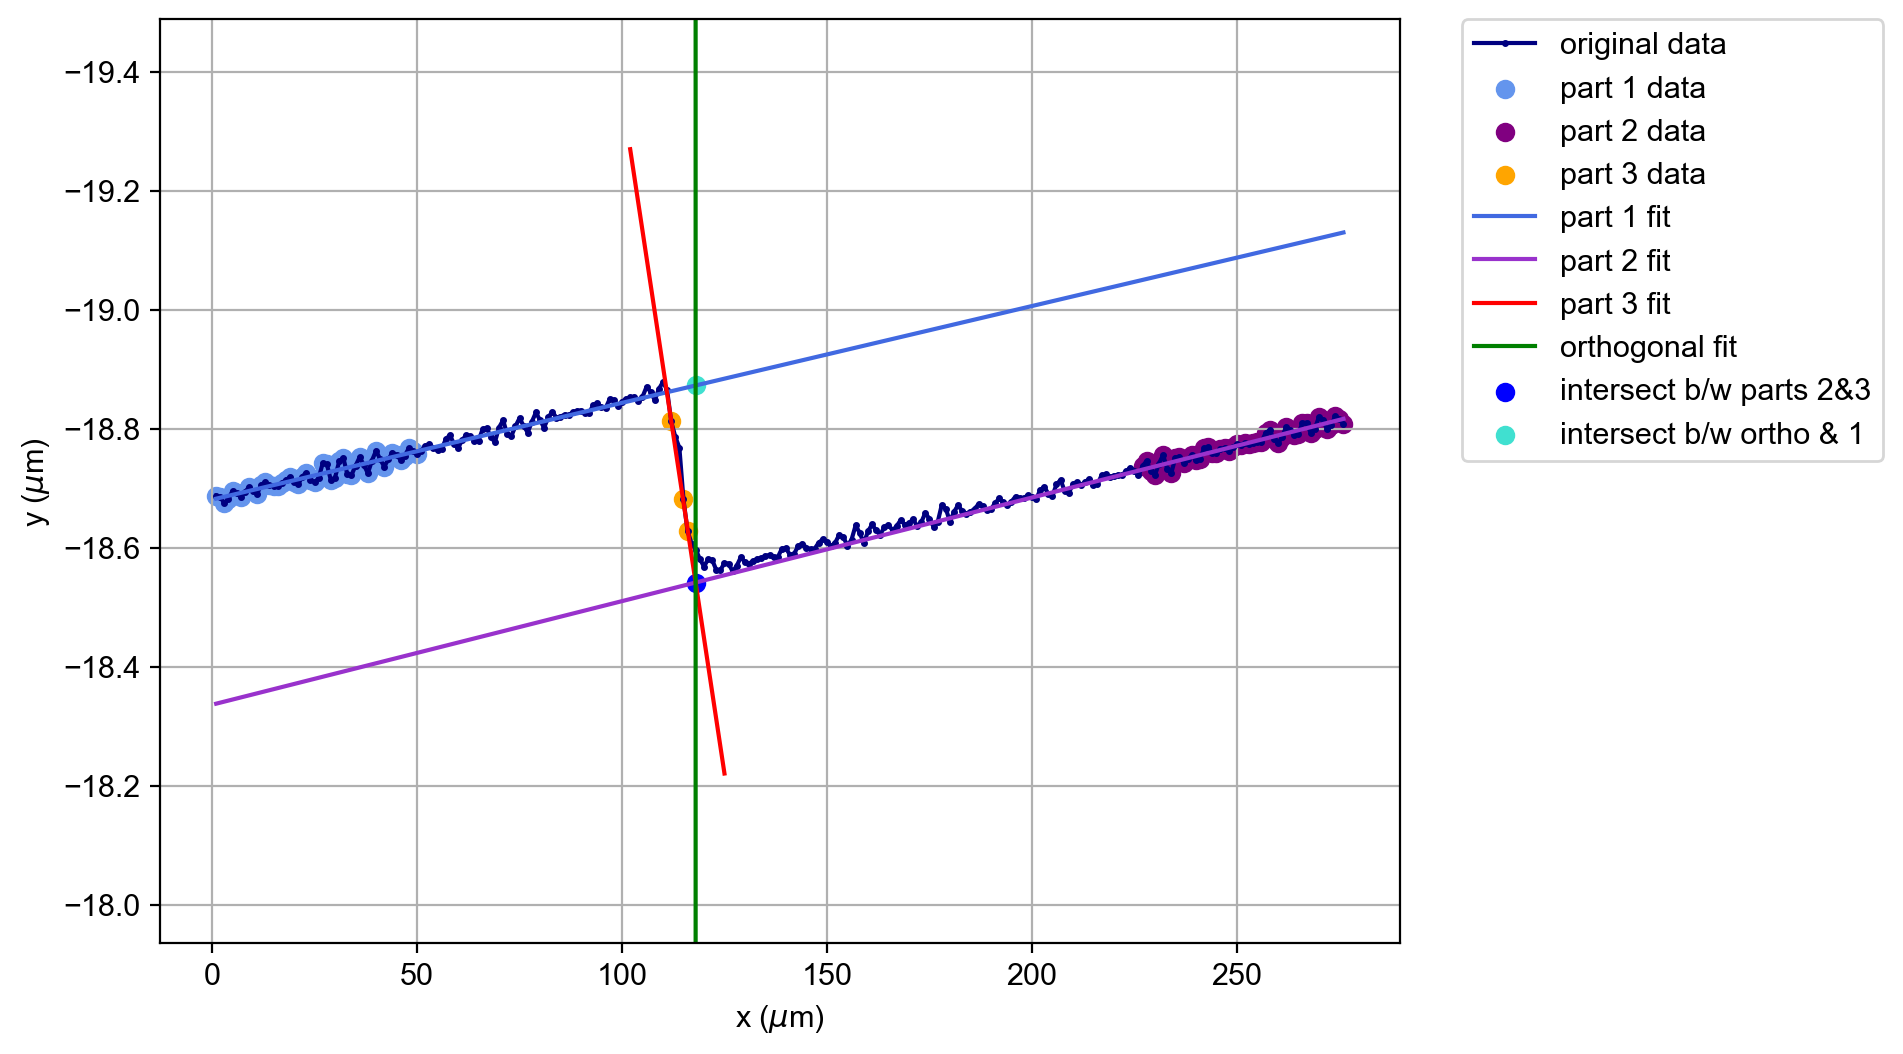

In [12]:
# example data file
data_path = '../sample_data/etch_sample_data/CF4/etched_(Thermal_SiO2)_15sec.xlsx'
x_data, y_data = get_data(data_path)
find_swangle_and_depth(x_data, y_data, 3)

# etched_(Thermal_SiO2)_15sec_2


In [13]:
# # example data file
# data_path = '../sample_data/etch_sample_data/CF4/etched_(Thermal_SiO2)_15sec_2.xlsx'
# x_data, y_data = get_data(data_path)
# y_data = 0.0001*y_data
# # xpart3, ypart3, xpart3extra, ypart3extra = find_cliff(x_data, y_data, 3)
# find_swangle_and_depth(x_data, y_data, 3)

# etched_(Thermal_SiO2)_15sec_3

cliff indices: [147, 148, 149]
Fit parameters: [-1.92335174e-03  1.02790655e+01]
R squared:  0.8484737333890435
RMSD:  0.011729404950166562
Fit parameters: [-1.86753229e-03  9.92925731e+00]
R squared:  0.9032275359782331
RMSD:  0.008821408633848182
Fit parameters: [-0.118625 27.438285]
R squared:  0.9958429408591566
RMSD:  0.006257895013502279
Intersection detected: (149.9606666487089, 9.649200918488633)
Intersection detected: (149.96130429186618, 9.990637133433477)
Etch depth: 0.34143681035391854 mirons


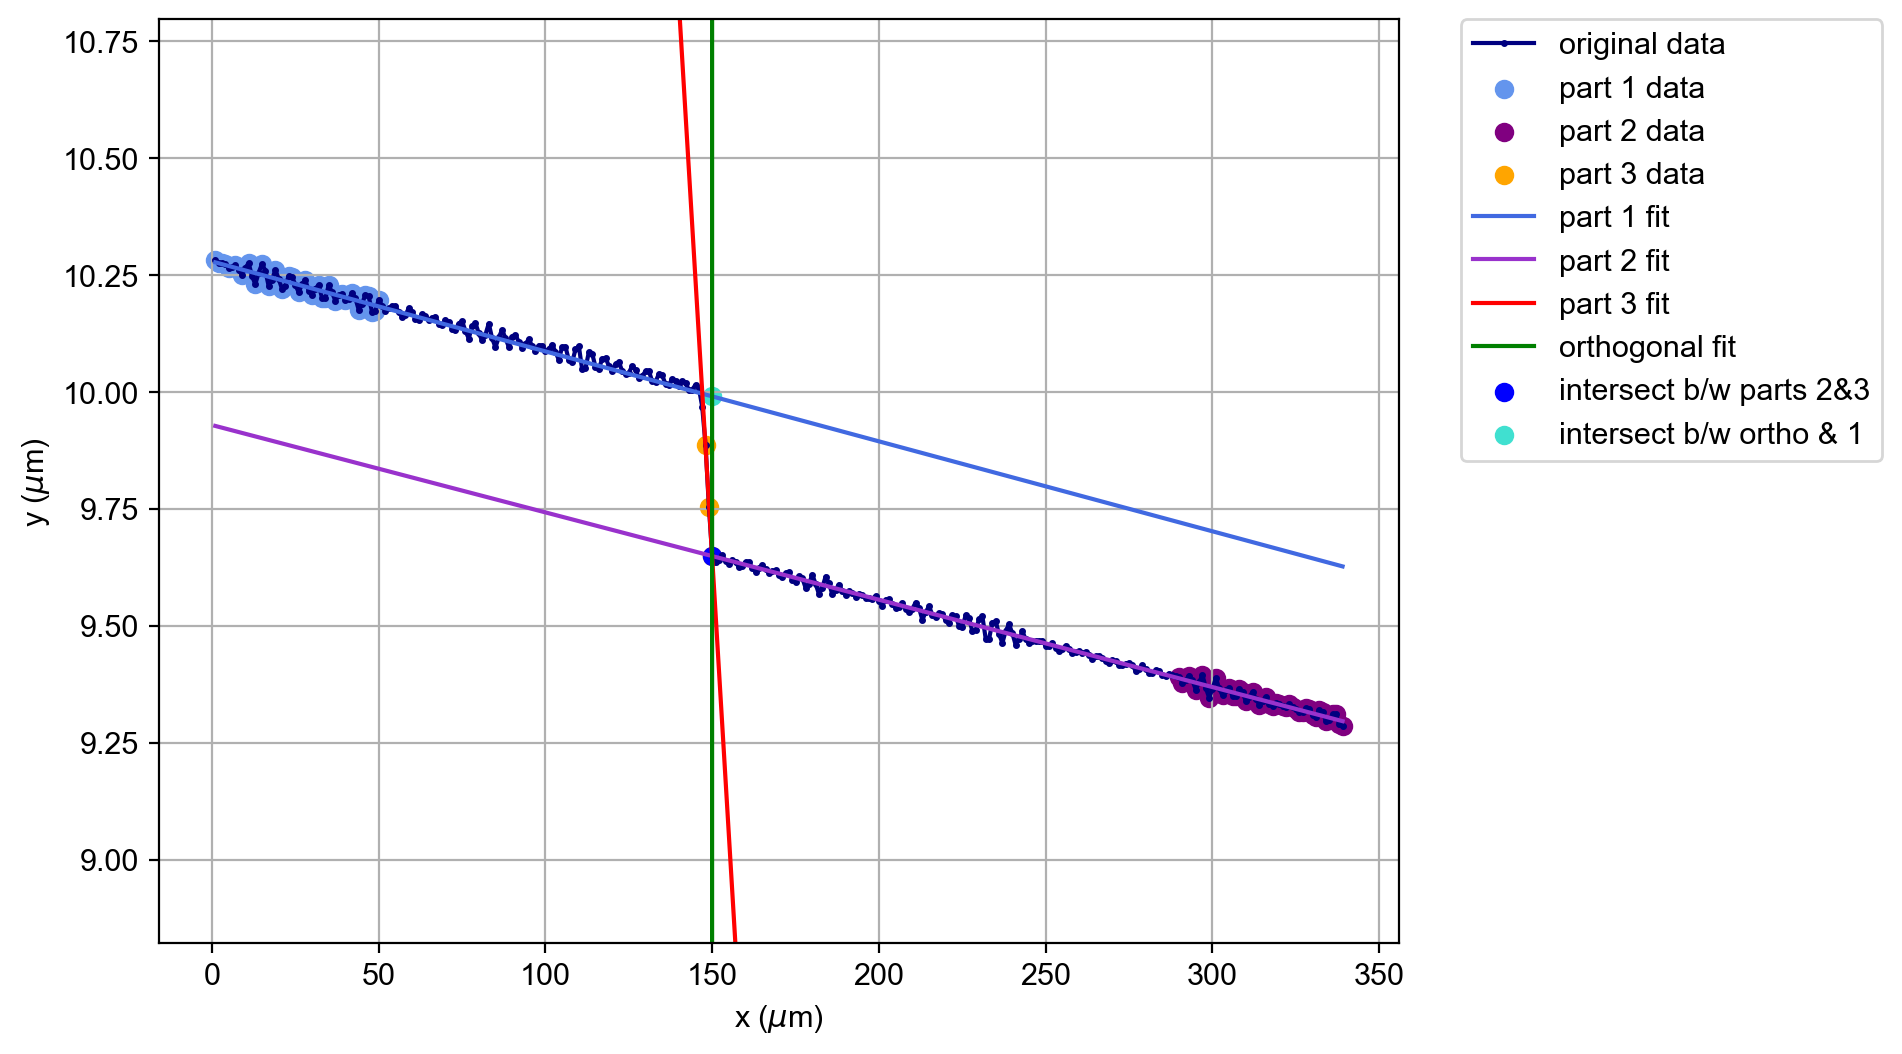

In [14]:
# example data file
data_path = '../sample_data/etch_sample_data/CF4/etched_(Thermal_SiO2)_15sec_3.xlsx'
x_data, y_data = get_data(data_path)
find_swangle_and_depth(x_data, y_data, 3)